In [1]:
import os
import re
import numpy as np
import pandas as pd
import sklearn
from sklearn.utils import shuffle

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

from tensorboard.plugins.hparams import api as hp

from scipy.sparse import csr_matrix
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.utils import class_weight



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saumyamehta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/saumyamehta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def preprocess(sent, lemmatizer, stop_words):
    
    alphabet = "abcdefghijklmnopqrstuvwxyz 0123456789',."
    sent = sent.lower()
    sent = sent.replace('@user','')
    sent = sent.replace('@[\w\-]+','')

    cleaned_sent_list = [char if char in alphabet else ' ' for char in sent] # remove all tags not in the alphabet

    cleaned_sent = ''.join(cleaned_sent_list)
    cleaned_sent_list = [lemmatizer.lemmatize(token) for token in cleaned_sent.split(" ")]
    cleaned_sent_list = [word for word in cleaned_sent_list if not word in stop_words]
    cleaned_sent = ' '.join(cleaned_sent_list)
    cleaned_sent = cleaned_sent.replace("n't",' not') # replace words like "isn't" with "is not"
    cleaned_sent = ' . '.join([x for x in cleaned_sent.split('.') if len(x)>0]) # remove multiple periods, and add spaces before and after a period
    cleaned_sent = ' , '.join([x for x in cleaned_sent.split(',') if len(x)>0]) # add spaces before and after a comma
    cleaned_sent = ' '.join(cleaned_sent.split()) # remove multiple spaces
    return cleaned_sent

In [3]:
olid_data = pd.read_csv("data/OLIDv1/olid-training-v1.0.tsv", sep='\t')


In [4]:
X_train = olid_data.tweet
y_train = pd.factorize(olid_data.subtask_a)[0]

X_test=pd.read_csv('data/OLIDv1/testset-levela.tsv',sep="\t").tweet
y_test=pd.read_csv( 'data/OLIDv1/labels-levela.csv',header=None).iloc[:,-1]
y_test = pd.factorize(y_test)[0]
import collections
collections.Counter(y_train)
print(f'X train shape: {X_train.shape}, y train shape: {y_train.shape}')


X train shape: (13240,), y train shape: (13240,)


Splitting data into train hold out sets.
Our split will be 80% train, 20% validation 

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size=0.2, random_state=42)
# check shapes of train, test and validation data
print(f'X train shape: {X_train.shape}, y train shape: {y_train.shape}')
print(f'X valid shape: {X_valid.shape}, y valid shape: {y_valid.shape}')
print(f'X valid shape: {X_test.shape}, y test shape: {y_test.shape}')


X train shape: (10592,), y train shape: (10592,)
X valid shape: (2648,), y valid shape: (2648,)
X valid shape: (860,), y test shape: (860,)


Data preprocessing. 

In [6]:

stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()
data_train = [preprocess(tweet,lemmatizer,stop_words) for tweet in X_train]
data_valid = [preprocess(tweet,lemmatizer,stop_words) for tweet in X_valid]
data_test = [preprocess(tweet,lemmatizer,stop_words) for tweet in X_test]

In [7]:
data_train[0], data_valid[0], data_test[0]

('leaving bb',
 'john kerry running mouth cared ha say think single damn thing kerry ha accomplished besides run mouth . trump accomplishment exceed anything kerry could ever dream of . even becoming president',
 'whoisq wherestheserver dumpnike declasfisa democrat support antifa , muslim brotherhood , ms13 , isis , pedophilia , child trafficking , taxpayer funded abortion s , election fraud , sedition treason lockthemallup wwg1wga qanon url')

In [8]:
vocab_size = 10000
embedding_size = 300
lstm_output_dim = 32
max_length = 200
trunc_type='post'
padding_type='post'
oov_tok = "<UNK>"

Tokenisation and padding for sentences


In [9]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(data_train)
word2int = tokenizer.word_index


In [10]:
train_sequences = tokenizer.texts_to_sequences(data_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

valid_sequences = tokenizer.texts_to_sequences(data_valid)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)



# Glove Embeddings
References: https://edumunozsala.github.io/BlogEms/jupyter/nlp/classification/embeddings/python/2020/08/15/Intro_NLP_WordEmbeddings_Classification.html

In [11]:
glove_path = "embeddings/glove.840B.300d.txt"

In [12]:
def get_word_vectors(word, *arr):
    return word, np.array(arr, dtype = 'float32')

In [13]:
def build_embedddings(embedding_path, word2int):
    embeddings = dict(get_word_vectors(*x.strip().split(" ")) for x in open(embedding_path))

    nwords = min(vocab_size, len(word2int))
    embedding_matrix = np.zeros((nwords, embedding_size))

    for word, index in word2int.items():
        if index >=vocab_size:
            continue

        embedding_vec = embeddings.get(word)
        if embedding_vec is not None:
            embedding_matrix[index] = embedding_vec

    return embedding_matrix




In [14]:
glove_embeddings = build_embedddings(glove_path, word2int)

In [15]:
print(glove_embeddings.shape)

(10000, 300)


# Building the model

RNN architecture: Embedding layer of size 100 -> lstm layer with output of 32 dimension -> linear layer activated by relu -> softmax to get probability 

In [16]:
# compute class weights : "https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html"
class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(y_train),
    y = y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights


{0: 1.5196556671449069, 1: 0.7451808076544252}

Hyperparameter tuning

In [17]:
# # Load the TensorBoard notebook extension
# %load_ext tensorboard
# !rm -rf ./logs/

In [18]:
# HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([100,150,200]))
# HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.05,0.2))
# HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
# METRIC_ACCURACY = 'accuracy'

# with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
#   hp.hparams_config(
#     hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
#     metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
#   )

In [19]:
# def train_test_model(vocab_size, embedding_size, max_length, hparams):
#     model = tf.keras.models.Sequential()
#     model.add(tf.keras.layers.Embedding(
#     vocab_size, embedding_size, 
#     embeddings_initializer=tf.keras.initializers.Constant(glove_embeddings),
#     input_length=max_length,trainable=False))
#     model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences = True)))
#     model.add(tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation="relu"))
#     model.add(tf.keras.layers.Dropout(hparams[HP_DROPOUT]))
#     model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
#     model.compile(
#     optimizer=hparams[HP_OPTIMIZER],
#     loss='binary_crossentropy',
#     metrics=['accuracy'],
#     )

#     model.fit(train_padded, y_train, batch_size=128,epochs=15,class_weight=class_weights,validation_data=(valid_padded, y_valid),
#     callbacks=[
#         tf.keras.callbacks.TensorBoard('logs/hparam_tuning'),  # log metrics
#         hp.KerasCallback('logs/hparam_tuning', hparams),  # log hparams
#     ]) # Run with 1 epoch to speed things up for demo purposes
#     _, accuracy = model.evaluate(test_padded, y_test)
#     return accuracy

In [20]:
# def run(run_dir, hparams):
#   with tf.summary.create_file_writer(run_dir).as_default():
#     hp.hparams(hparams)  # record the values used in this trial
#     accuracy = train_test_model(10000, 300, 280,hparams)
#     tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [21]:
# session_num = 0

# for num_units in HP_NUM_UNITS.domain.values:
#   for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
#     for optimizer in HP_OPTIMIZER.domain.values:
#       hparams = {
#           HP_NUM_UNITS: num_units,
#           HP_DROPOUT: dropout_rate,
#           HP_OPTIMIZER: optimizer,
#       }
#       run_name = "run-%d" % session_num
#       print('--- Starting trial: %s' % run_name)
#       print({h.name: hparams[h] for h in hparams})
#       run('logs/hparam_tuning/' + run_name, hparams)
#       session_num += 1

In [22]:
#%tensorboard --logdir logs/hparam_tuning

In [28]:
# Training loop and early stopping 

callbacks = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",mode="auto", patience = 5, restore_best_weights=True)
n_epochs = 25

In [29]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(
    vocab_size, embedding_size, 
    embeddings_initializer=tf.keras.initializers.Constant(glove_embeddings),
    input_length=max_length,trainable=True))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences = True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(30, return_sequences = True)))
model.add(tf.keras.layers.GlobalMaxPool1D())
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(20, activation="relu"))
model.add(tf.keras.layers.Dropout(0.05))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [30]:
model_trained = model.fit(train_padded, y_train, batch_size=128, epochs = n_epochs, 
verbose=2, class_weight=class_weights,validation_data=(valid_padded, y_valid), callbacks = [callbacks])

Epoch 1/25
83/83 - 25s - loss: 0.5593 - accuracy: 0.6921 - val_loss: 0.5471 - val_accuracy: 0.7285
Epoch 2/25
83/83 - 22s - loss: 0.4851 - accuracy: 0.7670 - val_loss: 0.4910 - val_accuracy: 0.7628
Epoch 3/25
83/83 - 23s - loss: 0.4583 - accuracy: 0.7900 - val_loss: 0.5512 - val_accuracy: 0.7255
Epoch 4/25
83/83 - 23s - loss: 0.4234 - accuracy: 0.8077 - val_loss: 0.5198 - val_accuracy: 0.7417
Epoch 5/25
83/83 - 22s - loss: 0.3780 - accuracy: 0.8317 - val_loss: 0.5138 - val_accuracy: 0.7727
Epoch 6/25
83/83 - 22s - loss: 0.3163 - accuracy: 0.8713 - val_loss: 0.6120 - val_accuracy: 0.7224
Epoch 7/25
83/83 - 22s - loss: 0.2472 - accuracy: 0.9046 - val_loss: 0.6988 - val_accuracy: 0.7217


In [35]:
test_sequences = tokenizer.texts_to_sequences(data_test)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [36]:
model_trained.history

{'loss': [0.5592703223228455,
  0.4850989282131195,
  0.4582862854003906,
  0.4233560264110565,
  0.3779955506324768,
  0.31633153557777405,
  0.2472420036792755],
 'accuracy': [0.6921261548995972,
  0.7669939398765564,
  0.7900302410125732,
  0.8076850175857544,
  0.8316653966903687,
  0.871317982673645,
  0.9046450257301331],
 'val_loss': [0.5471283197402954,
  0.49095433950424194,
  0.5512300729751587,
  0.5198259949684143,
  0.5138416290283203,
  0.6119751930236816,
  0.698760986328125],
 'val_accuracy': [0.7284743189811707,
  0.7628398537635803,
  0.7254531979560852,
  0.7416918277740479,
  0.7726585865020752,
  0.722432017326355,
  0.721676766872406]}

Text(0, 0.5, 'Accuracy')

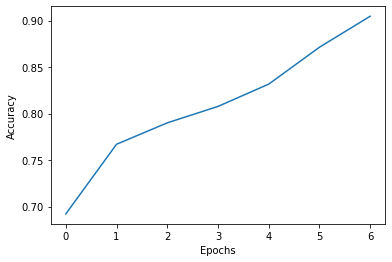

In [37]:
# PLotting accuracy of train
import matplotlib.pyplot as plt
plt.plot(model_trained.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


Text(0, 0.5, 'Validation Accuracy')

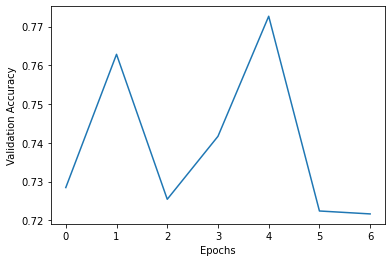

In [38]:
# PLotting accuracy of train
import matplotlib.pyplot as plt
plt.plot(model_trained.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

In [39]:

print(model.evaluate(test_padded,y_test))


27/27 [==============================] - 1s 38ms/step - loss: 0.4310 - accuracy: 0.7977
[0.4310244619846344, 0.7976744174957275]


In [41]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_padded, batch_size=128, verbose=1)
y_pred = (y_pred>0.5)
print(classification_report(y_test, y_pred))

7/7 [==============================] - 1s 97ms/step
              precision    recall  f1-score   support

           0       0.63      0.68      0.65       240
           1       0.87      0.85      0.86       620

    accuracy                           0.80       860
   macro avg       0.75      0.76      0.75       860
weighted avg       0.80      0.80      0.80       860

